In [1]:
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

2024-11-14 18:04:19.719226: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 18:04:19.747450: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 18:04:20.289332: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
file_path = tf.keras.utils.get_file("train.txt", 
    "https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt")

In [3]:
with open(file_path, 'r') as f:
    documents = f.readlines()

In [4]:
tagged_sentences = []
sentence = []

for line in documents:
    if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
        
    word, pos_tag, chunk_tag, ner = line.split(' ')   # 공백을 기준으로 속성을 구분 
    ner = re.sub('\n', '', ner)         #['German', 'JJ', 'B-NP', 'B-MISC\n'] 에서 줄바꿈 제거
    word = word.lower()                         # 단어들은 소문자로 바꿔서 저장
    sentence.append((word, ner))                # 단어와 개체명 태깅만 사용

In [5]:
tagged_sentences[0]

[('eu', 'B-ORG'),
 ('rejects', 'O'),
 ('german', 'B-MISC'),
 ('call', 'O'),
 ('to', 'O'),
 ('boycott', 'O'),
 ('british', 'B-MISC'),
 ('lamb', 'O'),
 ('.', 'O')]

In [6]:
inputs, labels = [], []

for pairs in tagged_sentences:
    words, tags = zip(*pairs)
    inputs.append(list(words))
    labels.append(list(tags))

샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.501887


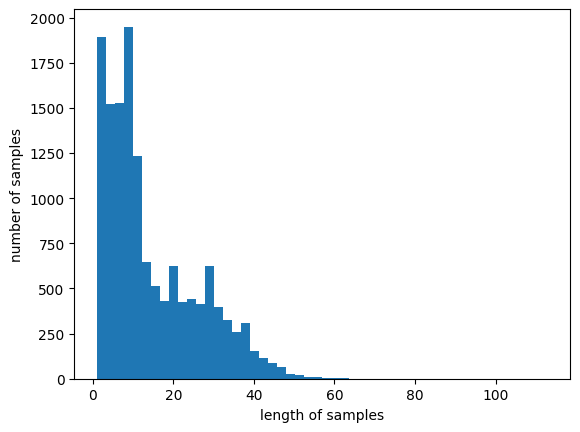

In [7]:
print('샘플의 최대 길이 : {}'.format(max([len(w) for w in inputs])))
print('샘플의 평균 길이 : {:4f}'.format(np.mean([len(w) for w in inputs])))
plt.hist([len(s) for s in inputs], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [8]:
MAX_LENGTH = 60
MAX_WORDS = 20000

In [9]:
train_sentences, test_sentences, train_tags, test_tags \
                = train_test_split(inputs, labels, test_size=0.2)

train_sentences, val_sentences, train_tags, val_tags \
                = train_test_split(train_sentences, train_tags, test_size=0.2)
len(train_sentences), len(val_sentences), len(test_sentences), len(train_tags), len(val_tags),len(test_tags)

(8985, 2247, 2809, 8985, 2247, 2809)

In [10]:
entity_tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
entity_tokenizer.fit_on_texts(train_sentences)

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(labels)

vocab_size = entity_tokenizer.num_words + 1      # MAX_WORDS
tag_size = len(tag_tokenizer.word_index) + 1       #전체 word_index 갯수

print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 20001
개체명 태깅 정보 집합의 크기 : 10


In [11]:
X_train = entity_tokenizer.texts_to_sequences(train_sentences)
y_train = tag_tokenizer.texts_to_sequences(train_tags)

X_val = entity_tokenizer.texts_to_sequences(val_sentences)
y_val = tag_tokenizer.texts_to_sequences(val_tags)

X_test = entity_tokenizer.texts_to_sequences(test_sentences)
y_test = tag_tokenizer.texts_to_sequences(test_tags)

len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(8985, 8985, 2247, 2247, 2809, 2809)

In [12]:
X_train_padded = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
X_val_padded = pad_sequences(X_val, maxlen=MAX_LENGTH, padding='post')
X_test_padded = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')
y_train_padded = pad_sequences(y_train, maxlen=MAX_LENGTH, padding='post')
y_val_padded = pad_sequences(y_val, maxlen=MAX_LENGTH, padding='post')
y_test_padded  = pad_sequences(y_test, maxlen=MAX_LENGTH, padding='post')
 
print(X_train_padded[0])
print(X_val_padded[0])
print(X_test_padded[0])
print(y_train_padded[0])
print(y_val_padded[0])
print(y_test_padded[0])

[1356   15  221  125  562 2658   69    5    2  146  516  123    3    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[ 948  704  230 1073    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[3235  851    7    1    6  528   81   26  112    2  386 2917    1   13
    1    1    6   34   45 4842    6    8 1723    3    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[2 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 

In [13]:
y_train_onehot = to_categorical(y_train_padded, tag_size)
y_val_onehot = to_categorical(y_val_padded, tag_size)
y_test_onehot = to_categorical(y_test_padded, tag_size)

In [14]:
# Train, validation, test dataset 생성 및 배치 단위로 분리
batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_padded, y_train_onehot)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_padded, y_val_onehot)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_padded, y_test_onehot)).batch(batch_size)

2024-11-14 18:04:22.107695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 18:04:22.137862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 18:04:22.137906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 18:04:22.146264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 18:04:22.146310: I tensorflow/compile

In [15]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def rnn_mtm_model(vocab_size, dim_lst, loss_fn, optimizer, metrics):
    # Define the input layer
    inputs = Input(shape=(None,))  # None은 가변적인 길이를 의미합니다.
    x = Embedding(vocab_size, dim_lst[0])(inputs)
    x = Bidirectional(LSTM(dim_lst[1], return_sequences=True))(x)
    outputs = Dense(dim_lst[2], activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)

    return model

# 모델 생성
vocab_size = vocab_size  # 예시로 어휘 크기 설정
dim_lst = [128, 256, 10]
loss_fn = 'categorical_crossentropy'
optimizer = Adam(0.001)
metrics = ['accuracy']
model = rnn_mtm_model(
    vocab_size=vocab_size, dim_lst=dim_lst, loss_fn=loss_fn, optimizer=optimizer, metrics=metrics
)

# Model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         2560128   
                                                                 
 bidirectional (Bidirection  (None, None, 512)         788480    
 al)                                                             
                                                                 
 dense (Dense)               (None, None, 10)          5130      
                                                                 
Total params: 3353738 (12.79 MB)
Trainable params: 3353738 (12.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
import time
# 모델 학습 시간 측정
start_time = time.time()

# 모델 학습 (검증 데이터 포함)
epochs = 2

history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, verbose=1)

# 모델 테스트 평가
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
end_time = time.time()
evaluation_time = end_time - start_time
print(f"Evaluation Time: {evaluation_time:.2f} seconds")

Epoch 1/2


2024-11-14 18:04:29.115208: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-14 18:04:29.146826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-14 18:04:29.176551: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2ce1305420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-14 18:04:29.176599: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-14 18:04:29.179732: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-14 18:04:29.257870: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

71/71 [==============================] - 38s 492ms/step - loss: 0.4313 - accuracy: 0.9034 - val_loss: 0.2061 - val_accuracy: 0.9570
Epoch 2/2
22/22 [==============================] - 3s 156ms/step - loss: 0.1686 - accuracy: 0.9590
Test Loss: 0.1686, Test Accuracy: 0.9590
Evaluation Time: 49.28 seconds


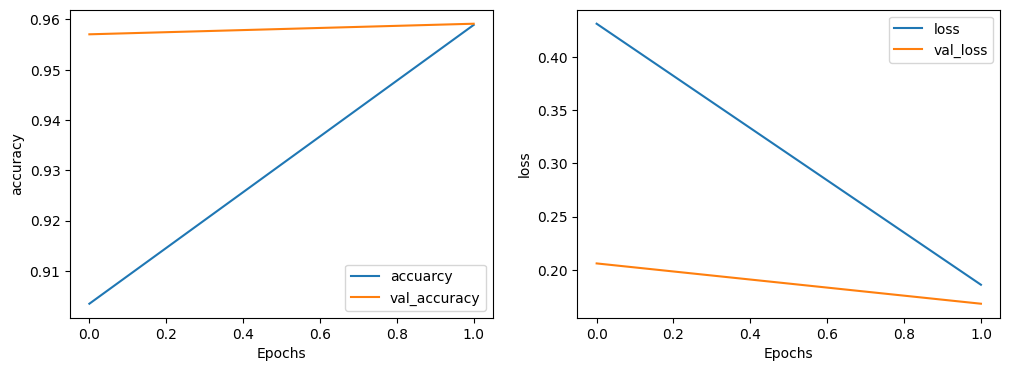

In [18]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('Epochs')
ax1.set_ylabel('accuracy')
ax1.legend(['accuarcy', 'val_accuracy'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('loss')
ax2.legend(['loss', 'val_loss'])
plt.show()